# Decision Tree from Scratch on UCI Iris (Binary, 2D)

**Goal:**  
1. Load Iris data (only setosa vs. versicolor, two features).  
2. Implement Gini impurity.  
3. Find the best split on the root node.  
4. Grow a single-level tree and classify a test point.  
5. Recursively build a small tree (max_depth=2).  
6. Visualize decision regions.

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections import Counter


## 1. Data Preparation

We load the Iris dataset, keep only classes 0 (setosa) and 1 (versicolor), and restrict to the first two features: sepal length and sepal width.

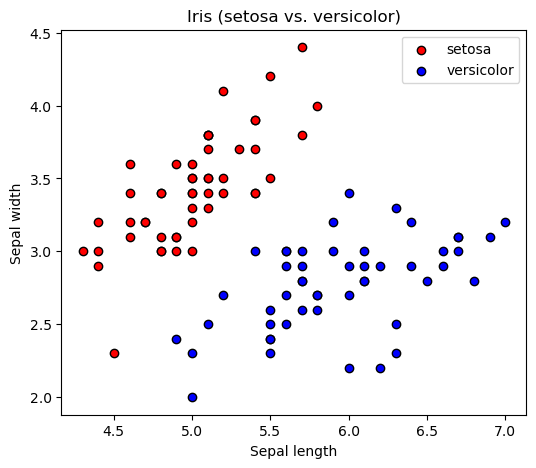

In [2]:
# load and filter
data = load_iris()
X_all, y_all = data.data, data.target
mask = (y_all == 0) | (y_all == 1)
X = X_all[mask, :2]   # first two features
y = y_all[mask]

# plot
plt.figure(figsize=(6,5))
for cls, color, label in zip([0,1], ['red','blue'], data.target_names[:2]):
    plt.scatter(X[y==cls,0], X[y==cls,1], c=color, label=label, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
plt.title('Iris (setosa vs. versicolor)')
plt.show()


## 2. Implementing Gini Impurity

The Gini impurity of a label‐array `y` is  
`Gini(y) = 1 - Σₖ (pₖ)²`  
where pₖ = fraction of class k.

In [3]:
def gini(y):
    counts = np.bincount(y)
    p = counts / counts.sum()
    return 1 - np.sum(p**2)

# quick tests
print("All one class →", gini(np.array([0,0,0,0])))        # 0.0
print("Half-half    →", gini(np.array([0,1,0,1])))        # 0.5
print("3 zeros,1 one→", gini(np.array([0,0,0,1])))        # 0.375


All one class → 0.0
Half-half    → 0.5
3 zeros,1 one→ 0.375


## 3. Finding the Best Split at a Node

For each feature `j` and each threshold `t` (mid-point between sorted unique values),  
- split into left/right  
- compute weighted Gini  
- pick the (j*, t*) that **minimizes** it

In [4]:
def best_split(X, y):
    n, p = X.shape
    best = {'feature':None, 'thresh':None, 'gini':np.inf}
    for j in range(p):
        vals = np.unique(X[:,j])
        thresholds = (vals[:-1] + vals[1:]) / 2.0
        for t in thresholds:
            left_mask  = X[:,j] <= t
            right_mask = X[:,j] >  t
            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue
            g_left  = gini(y[left_mask])
            g_right = gini(y[right_mask])
            w = left_mask.sum() / n
            g_split = w * g_left + (1-w) * g_right
            if g_split < best['gini']:
                best.update({'feature':j, 'thresh':t, 'gini':g_split})
    return best

# test on root node
split = best_split(X, y)
print("Best split:", split)


Best split: {'feature': 0, 'thresh': np.float64(5.45), 'gini': np.float64(0.19567827130852344)}


## 4. Single-Level Decision Tree and Classify a Test Point

1. Use the best split to form two leaf nodes.  
2. Each leaf's prediction = majority class.  
3. Classify an example test point.

Split on feature 0 at 5.45
Left leaf class: 0   Right leaf class: 1
Test point [5. 3.] → predict class 0


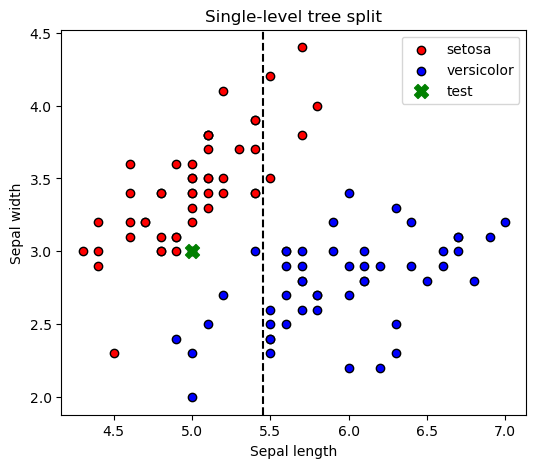

In [5]:
j, t = split['feature'], split['thresh']
left_mask  = X[:,j] <= t
right_mask = X[:,j] >  t
pred_left  = Counter(y[left_mask]).most_common(1)[0][0]
pred_right = Counter(y[right_mask]).most_common(1)[0][0]

print(f"Split on feature {j} at {t:.2f}")
print("Left leaf class:", pred_left, "  Right leaf class:", pred_right)

# classify a new test point
x_test = np.array([5.0, 3.0])
y_pred = pred_left if x_test[j] <= t else pred_right
print("Test point", x_test, "→ predict class", y_pred)

# plot with the test point
plt.figure(figsize=(6,5))
plt.scatter(X[y==0,0],X[y==0,1],c='red',label='setosa',edgecolor='k')
plt.scatter(X[y==1,0],X[y==1,1],c='blue',label='versicolor',edgecolor='k')
plt.scatter([x_test[0]],[x_test[1]],c='green',s=100,label='test',marker='X')
if j==0:
    plt.axvline(t, color='black', linestyle='--')
else:
    plt.axhline(t, color='black', linestyle='--')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
plt.title('Single-level tree split')
plt.show()


## 5. Recursively Building a Tree (max_depth = 2)

We'll represent the tree as nested dicts:
```
{
  'feature': j,
  'thresh': t,
  'left':  <subtree or class>,
  'right': <subtree or class>
}
```
Stop when depth = `max_depth` or number of samples < `min_samples`.

In [6]:
def build_tree(X, y, depth=0, max_depth=2, min_samples=5):
    # stopping conditions
    if len(np.unique(y)) == 1 or depth == max_depth or len(y) < min_samples:
        return Counter(y).most_common(1)[0][0]
    split = best_split(X, y)
    if split['feature'] is None:
        return Counter(y).most_common(1)[0][0]
    j, t = split['feature'], split['thresh']
    left_mask  = X[:,j] <= t
    right_mask = X[:,j] >  t
    left_subtree  = build_tree(X[left_mask],  y[left_mask],  depth+1, max_depth, min_samples)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth+1, max_depth, min_samples)
    return {'feature':j, 'thresh':t, 'left': left_subtree, 'right': right_subtree}

# build and inspect
tree = build_tree(X, y, max_depth=2, min_samples=5)
import pprint; pprint.pprint(tree)


{'feature': 0,
 'left': {'feature': 1,
          'left': np.int64(1),
          'right': np.int64(0),
          'thresh': np.float64(2.8)},
 'right': {'feature': 1,
           'left': np.int64(1),
           'right': np.int64(0),
           'thresh': np.float64(3.45)},
 'thresh': np.float64(5.45)}


## 6. Predict via the Learned Tree

A small helper function to traverse our nested-dict tree.

In [7]:
def predict_tree(x, tree):
    if not isinstance(tree, dict):
        return tree
    j, t = tree['feature'], tree['thresh']
    branch = tree['left'] if x[j] <= t else tree['right']
    return predict_tree(x, branch)

# test on a grid
xx = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
yy = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
grid = np.array([[a,b] for a in xx for b in yy])
Z = np.array([predict_tree(pt, tree) for pt in grid])
Z = Z.reshape(len(xx), len(yy))


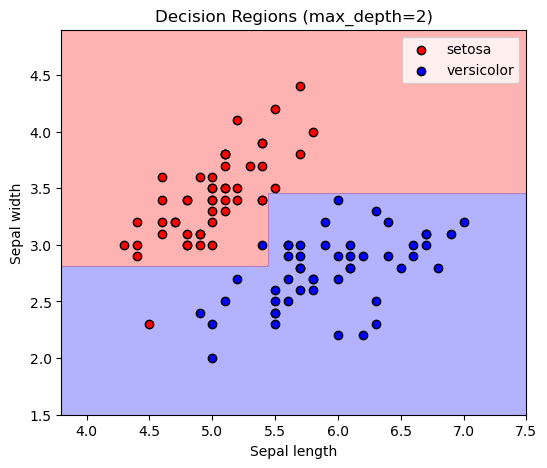

In [8]:
plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z.T, alpha=0.3, levels=[-0.5,0.5,1.5], colors=['red','blue'])
plt.scatter(X[y==0,0],X[y==0,1],c='red',edgecolor='k',label='setosa')
plt.scatter(X[y==1,0],X[y==1,1],c='blue',edgecolor='k',label='versicolor')
plt.xlabel('Sepal length'); plt.ylabel('Sepal width')
plt.legend(); plt.title('Decision Regions (max_depth=2)')
plt.show()


# What We Saw

- **Gini impurity** measures node “impurity.”  
- We manually searched over all features & thresholds to pick the best split.  
- Built a small binary tree of depth 2 by recursion.  
- Visualized the axis-aligned decision regions.

This “from-scratch” exercise helps you understand exactly how a CART-style tree decides where to split. In the next notebook, we’ll switch to `scikit-learn`’s optimized implementation and study how hyper-parameters affect performance.